# Gaussian Process Regression and Active Subspaces

**Author**: Spencer Lyon

**Date**: March 29, 2017

The purpose of this notebook is to explain the key numerical tools from ["Machine learning for high-dimensional dynamic stochastic economies" by Scheidegger and Bilionis (2017)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2927400)) (henceforth, S&B).

The main methodological contribution of this paper is the description of a novel function approximation technique that combines two tools from the Machine Learning literature: [Gaussian process regression](https://en.wikipedia.org/wiki/Gaussian_process) (GPR) and [active subspaces](http://activesubspaces.org/research/) (AS).

I will describe the basic mathematical theory behind these tools (meaning I leave out some of the details), then replicate a few of the illustrative examples S&B cover in their paper.


# Theory

## Gaussian process regression

GPR is a tool from machine learning we can use to approximate functions.  The notes in this section are derived from the treatment in [chapter 2](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf) of [Williams and Rasmussen (2006)](http://www.gaussianprocess.org/gpml), with some ideas from S&B.

GPR is a Bayesian regression method in function space. We will compute interpolated values as a function of the posterior mean, where the accuracy of the approximation is expressed as a function of the posterior (co)variance. As is typical with Bayesian methods, we will construct the posterior distribution by combining a prior and a likelihood. Below, I describe how to characterize the prior and likelihood, how to combine them into the posterior, as well as how to compute interpolated values.


### Setup
 
Let $f : \mathbb{R}^D \rightarrow \mathbb{R}$ represent a function we want to approximate. In economic examples this might be a value or a policy function.

Suppose that we have $N$ input-output observations of the form of the form $X := \begin{bmatrix} x_1 & x_2 & \cdots & x_N \end{bmatrix}$ and $V := \begin{bmatrix} v_1 & v_2 & \cdots & v_N \end{bmatrix}^T$, where $X$ is $D \times N$, $V$ is $N \times 1$, and $v_i$ is our candidate value for $f(x_i)$. I will sometimes refer to $(X, V)$ as the _training data_. Also, I will use notation $F$ to refer to the true value of $f$ evaluated at all the points in $X$: $F \stackrel{\Delta}{=} \begin{bmatrix} f(x_1) & f(x_2) & \cdots & f(x_N) \end{bmatrix}^T$

> NOTE: I use the language "candidate value" because in our applications $f$ is typically not known exactly (we are solving for it!) and we will only be able to provide a guess for what $f(x)$ should be at our input points $x \in X$.

*Definition*: A **Gaussian Process** is a collection of random variables, any finite number of which have a joint multivariate normal distribution.

As the mean and covariance are sufficient statistics for a multivariate normal distribution, a gaussian process is fully specified by a mean and covariance function. We can write the mean and covariance functions of our function $f$ as

$$m(x) = E[f(x)]$$
$$k(x, x') = E[(f(x) - m(x))(f(x') - m(x'))]$$

and we would write the gaussian process as

$$
f(x) \sim \mathcal{G}\mathcal{P}(m(x), k(x,x')).
$$

### Prior

In GPR, the formation of a prior happens when a mean and covariance function are chosen.

S&B use the zero-mean function ($m(x) = 0 \; \forall x$) and choose the [squared Euclidean (or radial basis function) kernel](http://scikit-learn.org/stable/modules/gaussian_process.html#radial-basis-function-rbf-kernel) defined as:

$$
k(x,x') = s^2 \exp \left(-\frac{1}{2} \sum_{i=1}^D \left(\frac{x_i - x_i'}{l_i}\right)^2 \right)
$$

where $\theta \stackrel{\Delta}{=} (s, \{l_i\}_{i=1}^{D})$ are the _hyperparameters_ of the prior distribution. 

>NOTE: The zero-mean and squared Euclidean kernel are also the reccomendations in Williams and Rasmussen (W&R). W&R prove that the use of the squared Euclidean kernel makes Gaussian process regression equivalent to Bayesian linear regression with an infinite number of basis functions -- so it seems like a good choice to me!

If $\hat{X} \in \mathbb{R}^{D \times n}$ and $\hat{X}' \in \mathbb{R}^{D \times n'}$ are sets of $n$ and $n'$ input points, let $K(\hat{X},\hat{X}')$ be the $n \times n'$ cross-covariance matrix. The $i,j$ element is $k(\hat{x}_i, \hat{x}_j')$. Also denote $m(X) = \begin{bmatrix} m(x_1) & m(x_2) & \cdots & m(x_N) \end{bmatrix}^T$

Given this setup, the prior (here a distribution over the samples of $f$) is represented as:

$$
F \bigm\vert X, \theta \sim N \big(m(X), K(X,X) \big)
$$

Notice a few things about the prior:


1. The prior is a function of the training _inputs_ $X$, but not the proposed values $V$.
2. A sample from the prior is a vector in $\mathbb{R}^N$.
3. To evaluate the prior we need values for the hyperparameters. These are usually solved for using maximum likelihood given the training data (I skip a detailed discussion of this step).


### Likelihood

The likelihood is a distribution for the proposed funciton values, given the data and hyperparameters $V \bigm\vert  X, \theta$.

To construct the likelihood, we need to make an assumption about the distribution of $V$. We will follow S&B (who, in turn, follow R&W) and assume

$$
v_i = f(x_i) + \sigma_n \epsilon
$$

where $\epsilon \stackrel{\text{i.i.d.}}{\sim} N(0, 1)$ is noise and $\sigma_n$ is the standard deviation of the _noise_ in our estimates of $f$ in the samples $(X, V)$. Note that $\sigma_n$ is another hypterparaemter we need to optimize over, so it is included as part of $\theta$.

Because we've assumed that $\epsilon$ is i.i.d., the distribution of all the samples is given by 

$$
V \bigm\vert F, \theta \sim N\left(F, \sigma_n^2 I_N\right)
$$

where $I_N$ is the $N \times N$ identity matrix. Finally, we write the likelihood of observing the training data $(X, V)$ as

$$
V \bigm\vert X, \theta \sim N \bigm(m(X), K(X, X) + \sigma_n^2 I_N \bigm)
$$

> NOTE: this last step is still a little to fuzzy to me. This is how it is presented both in S&B and W&R, so for now I am trusting that it is correct.

### Posterior

The posterior distribution is given by Bayes' Law:

$$
\text{posterior} \propto \text{prior} \times \text{likelihood}
$$

As shown above, the prior and likelihood are both Gaussian. A Gaussian prior and likelihood form a [conjugate pair](https://en.wikipedia.org/wiki/Conjugate_prior), which means that the posterior is known in closed form and in our case is also Gaussian. Armed with this information, we compute the posterior distribution at a point $x \in \mathbb{R}^D$ in closed form as

$$
f(x) \bigm\vert X, V, \theta \sim N \left(\tilde{m}(x), \tilde{k}(x, x)\right),
$$

where



$$\tilde{m}(x) \stackrel{\Delta}{=} m(x) + K(x, X)\bigm(K(X,X) + \sigma_n^2 I_N\bigm)^{-1}(V - m(X))$$
$$\tilde{k}(x,x') \stackrel{\Delta}{=} k(x, x') - K(x, X)\bigm(K(X,X) + \sigma_n^2 I_n\bigm)^{-1} K(X, x').$$

$\tilde{m}(x)$ and $\tilde{k}(x, x)$ are known as the _predictive mean_ and _predictive variance_, respectively. Note that $\tilde{m}(x) \in \mathbb{R}$ and $\tilde{k}(x, x) \in \mathbb{R}$.

### Interpolation

We can use the predictive mean to construct approximate of $f$ for any $x \in \mathbb{R}^D$. 

To see how, define

$$
\alpha \stackrel{\Delta}{=} \bigm(K(X,X) + \sigma_n^2 I_n \bigm)^{-1}(V - m(X)).
$$

and notice that the equation for $\tilde{m}(x)$ can be written as the sum of $\tilde{m}(x) = m(x) + K(x, X) \cdot \alpha$.

With this insight, we can consider the elements of $K(x, X)$ as the evaluation of $N$ symmetric Gaussian basis functions centered at each observation input (centered at each $x \in X$) while $\alpha$ is the corresponding coefficient vector.



We compute an approximated value of $f(x)$ as $\hat{f}(x) \stackrel{\Delta}{=} m(x) + K(x, X) \cdot \alpha = m(x) + \sum_{i=1}^N k(x, x_i) \alpha_i$.

### Comments

A few observations:

- Given our choice of the squared euclidean kernel and zero mean function, approximation following this scheme is interpolating (meaning $\hat{f}(x_i) = v_i$).
- The cost of evaluating $\hat{f}(x)$ increasing in both $D$ and $N$ as computing $\tilde{m}(x)$ requires that we compute $K(x, X)$, which is the squared Euclidean distance between $x$ and all $N$ points in $X$. The cost of each of these distance calculations is increasing in $D$.
- There is scope for parallelization when computing $\hat{f}(x)$ because each term of $\sum_{i=1}^N k(x_i, x) \alpha_i$ can be computed simultaneously.
- We can use the predictive variance as a measure of the accuracy of the approximation. Specifically, the distribution of $\hat{f}(x)$ is $N \left(f(x), \tilde{k}(x, x) \right)$. So, if we wanted to plot $\hat{f}(x)$ with 95% confidence bands we could plot $\hat{f}(x)$ as well as $\hat{f}(x) \pm 1.96\sqrt{\tilde{k}(x, x)}$

## Active Subspaces

These notes are my summary of the exposition in S&B.

Active subspaces are a set of tools used for dimensionality reduction. The core concept is to suppose that the function $f$ we want to approximate is itself well approximated by

$$
f(x) \approx h(W^T x)
$$

where the matrix $W \in \mathbb{R}^{D \times d}$ projects from the high dimensional input space $\mathbb{R}^D$ to the lower dimensional _active subspace_ $\mathbb{R}^d$ and $h: \mathbb{R}^d \rightarrow \mathbb{R}$ is called the _link_ function. 

> NOTE: All matrices $W$ that span the same subset of $\mathbb{R}^d$ work identically. S&B find it useful to focus on matrices with orthogonal columns. This allows us to interpret the columns of $W$ as the directions in $\mathbb{R}^D$ as directions of steepest change for $f$. As these directions encoded in the gradient of f, $\nabla f$, we can use what we know about $\nabla f$ to find an appropriate matrix $W$.

This leaves us with three main problems:

1. How to determine $d$
2. How to find the matrix $W$
3. What to choose as the function $h$

### Determining $d$ and $W$

The algorithms for finding $d$ and $W$ are related, so we talk about them together.

Suppose that in addition to $X$ and $V$ we also have the gradient of $f$ at each point in $X$. That is we have a matrix $G \in \mathbb{R}^{D \times N}$  where

$$ 
G = [g_1 \; g_2 \; \cdots \; g_N]
$$

and $g_i = \nabla f(x_i) = \begin{bmatrix} \frac{\partial f}{\partial x_{i1}} & \frac{\partial f}{\partial x_{i2}} & \cdots & \frac{\partial f}{\partial x_{iD}} \end{bmatrix}^T$.

Now let $\rho(x)$ be some PDF on $\mathbb{R}^D$, such as the PDF of a uniform distribution. Then define 

$$ 
C = \int (\nabla f(x)) (\nabla f(x))' \rho(x) dx
$$

$C$ is symmetric and positive definite and can be written as $C = V \Lambda V^T$, where $\Lambda$ is a diagonal matrix whose elements are the eigenvalues of $C$ (meaning $\Lambda = \text{diag}(\lambda_1, \lambda_2, \cdots, \lambda_D)$ and $\lambda_i$ is the $i$th eigenvalue) and the columns of $V$ are the associated eigenvectors.

Now consider reordering the columns of  $\Lambda$ according to the size of the eigenvalues so that the largest eigenvalues appear in the first columns. Re-order the columns of $V$ appropriately and write them as

\begin{align*}
\Lambda &= \begin{bmatrix} \Lambda_{1} & 0 \\ 0 & \Lambda_2 \end{bmatrix} \\
V &= \begin{bmatrix}V_1 & V_2 \end{bmatrix}
\end{align*}

where 

\begin{align*}
\Lambda_1 &= \text{diag}(\lambda_1, \lambda_2, \cdots, \lambda_d) \\
\Lambda_2 &= \text{diag}(\lambda_{d+1}, \lambda_{d+2}, \cdots, \lambda_D) \\
V_1 &= \begin{bmatrix} v_1 & v_2 & \cdots & v_d]\end{bmatrix} \\
V_2 &= \begin{bmatrix}v_{d+1} & v_{d+2} & \cdots & v_D \end{bmatrix}
\end{align*}

We can then choose $d$ by examining the elements of $\Lambda$ and looking for when they approach zero (this will be obvious in examples).

The matrix $W$ is then $V_1$.

Now, in practice we can't compute $C$ directly. Instead we will make the _assumption_ that $\rho(X)$ is uniform and compute our approximation of $C$ as

$$
C_N = \frac{1}{N} \sum_{i=1}^{N} g_i g_i^T
$$

$C_N$ will be symmetric and positive definite, so we can use either the eigen decomposition or SVD to compute $\Lambda$ and $V$. In practice I've seen that the SVD is a better choice both because it is faster and also because the eigenvalues will be ordered.


### Choosing $h$

Choosing $h$ is not actually an issue when we want to apply this technique. What we do in practice is use the gradient information to construct $W$ and pick $d$. Then we transform all the input arguments $Y = W^T X$ and the use GPR to approximate $h$ from the transformed training data $(Y, V)$.

# Replications

In this section I will replicate some key figures from the paper.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.figure_formats = ['svg', 'pdf']

## Figure 1

I start by replicating part of the top right panel of figure 1. This demonstrates that the average and maximum error in a 2d Gaussian process regression is decreasing in the number of training points.

Note that I use the formula S&B call the average error, which is given by:

$$
e = \sqrt{\sum_{i=1}^N \left(f(x_i) - \tilde{m}(x_i) \right)^2 / f(x_i)^2}.
$$

> NOTE: it is not obvious to me why this is a measure of average error, but this is the equation and nomenclature from S&B, so I use it in the replication.

We will use the function

In [5]:
def f1(x):
    return np.abs(0.25 - x[0]**2 - x[1]**2)

and will use a randomly generated set of $N$ points on $\Delta^2$ (a two dimensional simplex)

In [6]:
def randDelta2(N):
    x = np.random.rand(N)
    return np.column_stack([x, 1-x])

In [7]:
def figure1():
    np.random.seed(39)
    num_Ns = 20
    ave_errs = np.inf * np.ones(num_Ns)
    max_errs = np.inf * np.ones(num_Ns)
    Nvals = np.logspace(1, 3, num_Ns)
    
    # construct test points
    X_test = randDelta2(1000)
    f1_test = f1(X_test.T)
    
    for i, N in enumerate(Nvals):
        # training points
        X = randDelta2(int(N))
        V = f1(X.T)
        
        # fit GP. note that the call to `gp.fit` below does
        # maximum likelihood optimization of priors for us
        gp = GaussianProcessRegressor(RBF())
        gp.fit(X, V)
        
        # compute error
        m_tilde = gp.predict(X_test)
        ave_errs[i] = np.sqrt(np.sum((f1_test - m_tilde)**2 / (f1_test**2)))
        max_errs[i] = np.max(np.abs(f1_test - m_tilde))
    
    fig, ax = plt.subplots(figsize=(8, 5.5))
    ax.loglog(Nvals, ave_errs, ".-", ms=15, label="Average error")
    ax.loglog(Nvals, max_errs, ".-", ms=15, label="Maximum error")
    ax.legend()
    
    return np.column_stack([ave_errs, max_errs]), fig

Note that when we run the function above some scary looking red warnings will appear. This OK. What is happening is that when the GPR routine does maximum likelihood to it wanders into regions of the state space where the log-likelihood function that is being used is not well defined. When this happens the optimizer simply chooses another search direction.

/home/john/anaconda3/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 4, 'warnflag': 2, 'grad': array([ 0.00091152]), 'funcalls': 59}
  " state: %s" % convergence_dict)
/home/john/anaconda3/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 2, 'warnflag': 2, 'grad': array([ 0.00327253]), 'funcalls': 45}
  " state: %s" % convergence_dict)
/home/john/anaconda3/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 0, 'warnflag': 2, 'grad': array([-7.53496059]), 'funcalls': 21}
  " state: %s" % convergence_dict)
/home/john/anaconda3/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarn

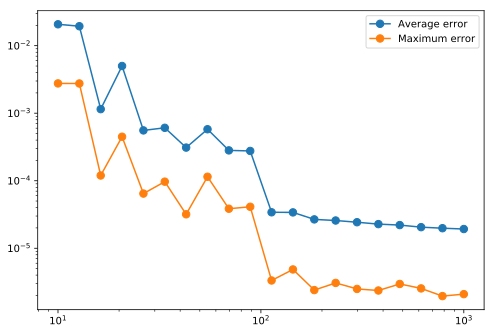

In [8]:
figure1();

The accuracy of using the posterior mean of our Gaussian process as a form of function approximation improves with the number of training points.

## Figure 3

I now move on to figure 3, demonstrates the procedure for constructing the active subspace and then compares the Gaussian process regression on the original subspace to the GPR on the active subspace.

For this example I will use a function

In [9]:
def f3(x):
    return np.exp(0.3*x[0] + 0.7*x[1])

def df3(x):
    "gradient of f3"
    val = f3(x)
    return np.column_stack([0.3*val, 0.7*val])

I will be evaluating this function on points in $\Omega \equiv [-1, 1]^2$

In [10]:
def randOmega(N, D=2):
    "random points on Ωᴰ := [-1, 1]ᴰ"
    return 2 * (np.random.rand(N, D) - 0.5)

In [11]:
def figure3():
    np.random.seed(43)
    Nvals = np.array([4, 8, 16, 32])
    num_Ns = len(Nvals)
    ave_errs_as = np.inf * np.ones(num_Ns)
    ave_errs = np.inf * np.ones(num_Ns)
    
    # construct test points
    X_test = randOmega(1000, 2)
    f1_test = f3(X_test.T)
    
    for i, N in enumerate(Nvals):
        # training points
        X = randOmega(N, 2)
        V = f3(X.T)
        G = df3(X.T)
        
        # find active subspace
        CN = (G.T @ G) / N
        vals, vecs = linalg.eigh(CN)
        W = vecs[:, 1]
        Y = X @ W
        
        # fit GP on active subspace
        gp_as = GaussianProcessRegressor(RBF())
        gp_as.fit(Y[:, None], V)
        m_tilde_as = gp_as.predict((X_test @ W)[:, None])
        ave_errs_as[i] = np.sqrt(np.sum((f1_test - m_tilde_as)**2 / (f1_test**2)) / N)
        
        # fit gp on input domain
        gp_as = GaussianProcessRegressor(RBF())
        gp_as.fit(X, V)
        m_tilde = gp_as.predict(X_test)
        ave_errs[i] = np.sqrt(np.sum((f1_test - m_tilde)**2 / (f1_test**2)) / N)

    
    fig, ax = plt.subplots(1, 2, figsize=(9, 5))
    ax[0].plot([1, 2], W, ".", ms=15)
    ax[0].set_xlabel("Input dimension")
    ax[0].set_xticks([1, 2])
    ax[0].set_ylabel("Magnitude of W")
    
    ax[1].semilogy(Nvals, ave_errs_as, ".-", label="ASGP", ms=15)
    ax[1].semilogy(Nvals, ave_errs, ".-", label="GP", ms=15)
    ax[1].legend()
    fig.tight_layout()
    return fig
    

/home/john/anaconda3/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 5, 'warnflag': 2, 'grad': array([ -2.15820037e-05]), 'funcalls': 55}
  " state: %s" % convergence_dict)
/home/john/anaconda3/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 1, 'warnflag': 2, 'grad': array([-9.64908174]), 'funcalls': 29}
  " state: %s" % convergence_dict)
/home/john/anaconda3/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 4, 'warnflag': 2, 'grad': array([-0.00597919]), 'funcalls': 49}
  " state: %s" % convergence_dict)


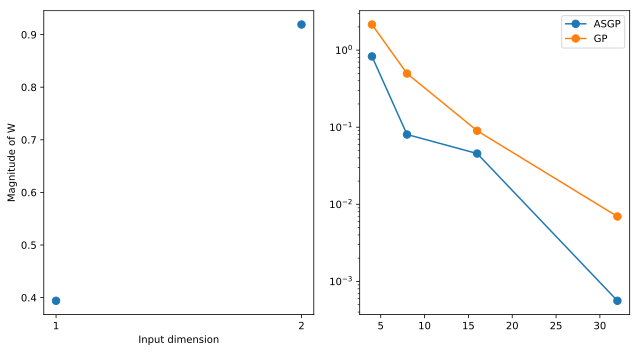

In [12]:
figure3();

Somewhat surprisingly the GPR is more accurate on the 1-dimensional active subspace instead of the 2-dimensional input space. I'm not 100% sure why this happens. However, one reason for this could be that the squared Euclidean kernel loses power as the number of dimensions increases. If we have some dimensions that really don't influence the value of $f$ very much, keeping them around only hurts the power of our chosen kernel, so the GPR might struggle to achieve high accuracy.

## Figure 4


In this example, we move to a higher dimensional function $f4 : \mathbb{R}^10 \rightarrow \mathbb{R}$. The function is just the exponential of a coefficient vector and a point $x \in \mathbb{R}^10$. 

In [13]:
def f4(x):
    return np.exp(0.01*x[0] + 0.7*x[1] + 0.02*x[2] + 0.03*x[3] + 0.04*x[4] + 
                  0.05*x[5] + 0.06*x[6] + 0.08*x[7] + 0.09*x[8] + 0.1*x[9])

def df4(x):
    val = f4(x)
    coefs = np.array([0.01, 0.7, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.09, 0.1])
    return val[:, None] * coefs[None, :]

Notice that the coefficient on the second component of $x$ is an order of magnitude larger than all the other coefficients, so the value of the second component will largely drive the value of $f4$. 

This means we should expect to see a 1 dimensional active subspace. 

To verify if our intuition is correct, we will plot both the set of eigenvalues of the matrix $C_N$ as well as the principal eigenvector of $C_N$.

In [14]:
def figure4():
    np.random.seed(41)
    N = 300
    X = randOmega(N, 10)
    V = f4(X.T)
    G = df4(X.T)
    CN = (G.T @ G) / N

    # find active subspace
    vals, vecs = linalg.eigh(CN)
    W = vecs[:, -1]
    
    fig, ax = plt.subplots(1, 2, figsize=(9, 5))
    x = np.arange(1, 11)
    ax[0].plot(x, vals, ".", ms=15)
    ax[0].set_xlabel("Sorted eigenvalues")
    ax[0].set_xticks(x)
    ax[0].set_ylabel("$\lambda$")
    
    ax[1].plot(x, W, ".", ms=15)
    ax[1].set_xlabel("Input dimension")
    ax[1].set_xticks(x)
    ax[1].set_ylabel("Magnitude of W")
    
    fig.tight_layout()
    return fig
    

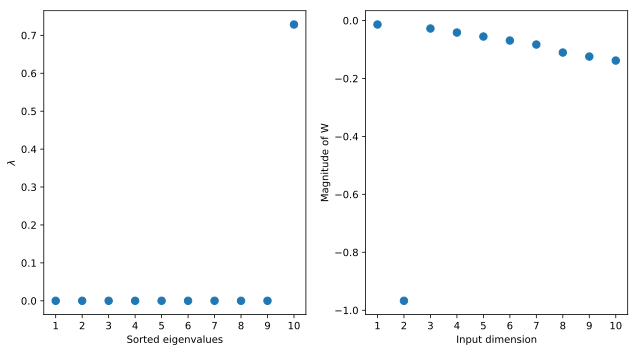

In [15]:
figure4();

From the left panel in this figure it is clear that there is a single active subspace.

From the right panel we see that it is the second dimension.

## Figure 5

In this example we modify the function used to produce figure 4 by multiplying it by $x_1$ and $x_2$. This effectively makes the function have a 3 dimensional active subspace.

This example is slightly different than what S&B present in that I plot the maximum absolute error on the 1,000 random testing points instead of what they refer to as the average error.

In [16]:
def f5(x):
    return x[1]*x[2] * f4(x)

def df5(x):
    _f4 = f4(x)
    val = np.atleast_1d(x[1] * x[2] * _f4)
    coefs = np.array([0.01, 0.7, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.09, 0.1])
    out = val[:, None] * coefs[None, :]
    out[:, 1] += x[2] * _f4
    out[:, 2] += x[1] * _f4
    return out

In [17]:
def figure5():
    np.random.seed(42)
    Nvals = np.array([10, 30, 100, 250, 500, 1000])
    num_Ns = len(Nvals)
    max_errs = np.inf * np.ones((num_Ns, 3))
    max_errs_gp = np.inf * np.ones(num_Ns)
    
    # construct test points
    X_test = randOmega(1000, 10)
    f_test = f5(X_test.T)

    for i, N in enumerate(Nvals):
        # training points
        X = randOmega(int(N), 10)
        V = f5(X.T)
        G = df5(X.T)
    
        CN = (G.T @ G) / N
        vals, vecs = linalg.eigh(CN)
        for d in range(3, 0, -1):

            # find active subspace of dimension d
            W = vecs[:, -d:]
            Y = X @ W

            # fit GP on active subspace
            gp_as = GaussianProcessRegressor(RBF(), n_restarts_optimizer=0)
            gp_as.fit(Y.reshape(N, d), V)
            m_tilde = gp_as.predict((X_test @ W).reshape(1000, d))
            max_errs[i, d-1] = np.max(np.abs(f_test - m_tilde))
        
        gp = GaussianProcessRegressor(RBF())
        gp.fit(X, V)
        m_tilde = gp.predict(X_test)
        max_errs_gp[i] = np.max(np.abs(f_test - m_tilde))
    
    fig, ax = plt.subplots(1, 2, figsize=(9, 5))
    x = np.arange(1, 11)
    ax[0].semilogy(x, vals, ".", ms=15)
    ax[0].set_xlabel("Sorted eigenvalues")
    ax[0].set_xticks(x)
    ax[0].set_ylabel("$\lambda$")
    
    ax[1].semilogy(Nvals, max_errs, ".-", ms=15)
    ax[1].semilogy(Nvals, max_errs_gp, ".-", ms=15)
    ax[1].legend([str(i) + "d AS" for i in range(1, 4)] + ["Full GP"])
    ax[1].set_xlabel("# of points")

    fig.tight_layout()
    return fig, max_errs

/home/john/anaconda3/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 3, 'warnflag': 2, 'grad': array([-0.00025588]), 'funcalls': 49}
  " state: %s" % convergence_dict)
/home/john/anaconda3/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'nit': 5, 'warnflag': 2, 'grad': array([ -7.00950623e-05]), 'funcalls': 50}
  " state: %s" % convergence_dict)


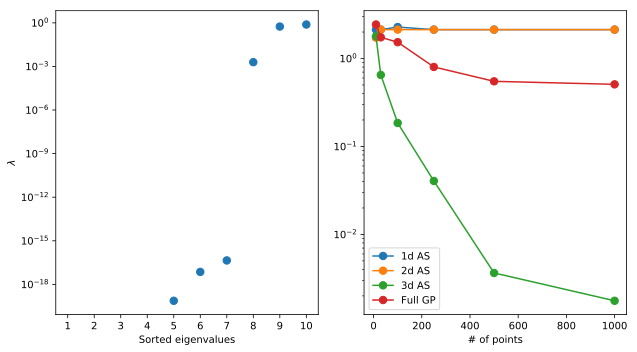

In [18]:
fig5, max_errs = figure5();

From the left panel we see that there are at most three dimensions to the active subspace (the largest eigenvalue is still 3 orders of magnitude larger than the 3rd largest, which I why we say "at most").

The right panel shows that only the 3d active subspace version shows a monotonically decreasing error as the number of training points rises.

> NOTE: This figure doesn't fully line up with Figure 5 in S&B. Notice the scale on the horizontal axes is on the order of 10^-3 in this figure, but 10^-7 in Figure 5 in S&B. I played with this for a while and was never able to achieve results on the same scale as theirs. My hunch is that the choice of where to locate the training points is increasingly important as the number of input dimensions increases. Here I'm just sampling from $[-1, 1]^{10}$ uniformly, which isn't necessarily an ideal choice of training points. Unfortunately S&B don't discuss how they choose training points, so we can just guess here. 

>For sake of completeness, in addition to uniformly sampled points I also tried using Sobol, Neiderreiter, Weyl, and Haber sequences to choose training points. I didn't see significant changes in the performance of the Active Subspace GPR, so I opted to keep things simple in the final version and stick to randomly sampling points. 